<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets nltk spacy -q


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт необходимых библиотек

In [169]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Union, Optional

import pandas as pd
import seaborn as sns
sns.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gosha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предложения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

Тренировочную выборку увеличим, добавив к ней `supervised` часть датасета, после чего весь датасет сформируем,убрав возможные *дубликаты*, преобразовав полученный список в объект класса `set`.

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']+dataset['unsupervised']['text']):
     sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(word_tokenize(x)) < word_threshold]
        )

  0%|          | 0/75000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 591419


In [9]:
sentences = list(set(sentences))
print("Всего предложений после удаления возможных дубликатов:", len(sentences))

Всего предложений после удаления возможных дубликатов: 562883


Посчитаем для каждого слова его встречаемость.

In [10]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(set(sentences)):
    for objects in word_tokenize(sentence):
        words[objects] += 1

  0%|          | 0/562883 [00:00<?, ?it/s]

In [11]:
len(words)

123469

In [12]:
print('Наиболее встречающиеся элементы', *words.most_common(10))

Наиболее встречающиеся элементы ('.', 488868) ('the', 446875) (',', 338009) ('a', 221902) ('and', 216327) ('of', 185548) ('to', 178417) ('is', 168432) ('it', 149700) ('i', 140292)


Ожидаемый результат: наиболее частыми элементами, попавшими в словарь оказались знаки пунктуации, служебные элементы английского языка.

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
for i in sorted(words, key = words.get, reverse=True)[:vocab_size]+['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(i)

In [14]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [16]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(sent_obj, self.unk_id) for sent_obj in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [19]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возможные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, eval_data) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_data:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, opt, crit, data_loader, eval_data, num_epoch: int = 5):

    # assert isinstance(model, nn.Module)
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(data_loader, desc=f'Training epoch {epoch}:'):
            opt.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = crit(logits, batch['target_ids'].flatten())
            loss.backward()
            opt.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, crit, eval_data))

    return {'model': model, 'losses': losses, 'perplexities': perplexities, 'epochs': num_epoch}

### Plot results

Визуализация результатов обучения

In [22]:
def plot_results(results: dict, figsize: tuple = (8, 4), dpi: int = 150):
    state = {'losses': 'Loss', 'perplexities': 'Perplexity'}
    fig, axs = plt.subplots(1, 2, figsize = figsize,  dpi = dpi, constrained_layout = True)

    for i, j in enumerate(state.keys()):
        sns.lineplot(x = range(results.get('epochs')), y = results.get(j), ax = axs[i])
        axs[i].set_xlabel('Epoch')
        axs[i].set_ylabel(' '.join([state.get(j), 'value']))
        axs[i].set_title(state.get(j))
    plt.suptitle('Results')
    plt.show()

### Generate sequence

Проверка работы модели путём генерации случайного текста.

In [23]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 64) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(wrd, word2ind['<unk>']) for wrd in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_w_distribution = model(input_ids)[-1] #[-1] - выбор последнего тензора из батча, который создаётся ОДНИМ предложением
            next_word = next_w_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])
    return words

### Нулевой эксперимент

Нулевой эксперимент предполагает создание `baseline` модели. Архитектурное решение для данной модели предполагает минимальную сложность, аналогично разобранному ранее решению из семинара. *Отличие* данной модели: несколько размеров скрытых слоёв.

In [24]:
class WordLM_0(nn.Module):
    def __init__(self,  vocab_size: int, hidden_dim: tuple, padding_ind: Optional[int] = None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim[0], padding_ind)
        self.rnn = nn.GRU(hidden_dim[0], hidden_dim[1], batch_first=True)
        self.linear = nn.Linear(hidden_dim[1], hidden_dim[1])
        self.projection = nn.Linear(hidden_dim[1], vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [120]:
model_0 = WordLM_0(hidden_dim=(300, 128), vocab_size=len(vocab), padding_ind=word2ind['<pad>']).to(device)
criterion_0 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_0 = torch.optim.Adam(model_0.parameters())

In [121]:
m0_results = train_model(model_0, optimizer_0, criterion_0, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3519 [00:00<?, ?it/s]

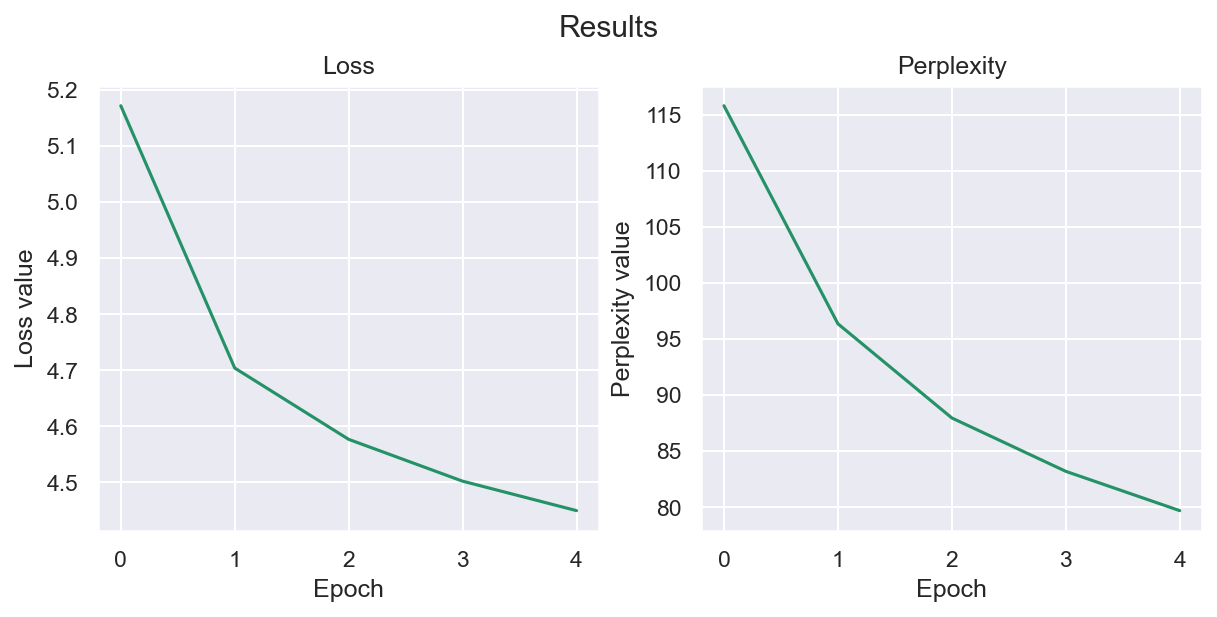

In [122]:
plot_results(m0_results)

In [123]:
print(f'Итоговое значение Perplexity:', round(evaluate(m0_results.get('model'), criterion_0, eval_dataloader), 2))

Итоговое значение Perplexity: 79.68


In [124]:
generate_sequence(m0_results.get('model'), starting_seq='the ultimate question of life, the universe, and everything', max_seq_len=128)

'<bos> the ultimate question of life , the universe , and everything is the only thing that is going to be a bit of a <unk> . <eos>'

### Первый эксперимент (2 балла)

Для модели подбираются гиперпараметры, определяющие строение и регуляризацию на её слоях, в архитектуру вносится изменение - добавляется скрытый слой перед слоем `projection`:
- Фиксируется размер вектора `embedding` для каждого слова;
- Измененяется количество нейронов в скрытых слоях (для скрытых слоёв предусмотрено несколько размеров);
- Используется параметр `dropout` для GRU слоя;
- Добавляется скрытый слой перед слоем `projection`.

In [128]:
class WordLM_1(nn.Module):
    def __init__(self,  vocab_size: int, hidden_dim: tuple, embedding_size: int = 300, padding_ind: Optional[int] = None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_ind)
        self.rnn = nn.GRU(embedding_size, hidden_dim[0], batch_first=True, num_layers = 2, dropout = 0.2)

        # Линейные слои для различных преобразований
        # Каждый линейный слой преобразует данные из размерности x в размерность y
        # Размерностям x и y соответствуют индексы 0 и 1 кортежа hidden_dim
        self.linear_12 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear_21 = nn.Linear(hidden_dim[1], hidden_dim[0])
        
        self.projection = nn.Linear(hidden_dim[0], vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # self.linear_11 = nn.Linear(hidden_dim[0], hidden_dim[0])
        # self.linear_22 = nn.Linear(hidden_dim[1], hidden_dim[1])

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim[0]]
        
        output = self.linear_12(self.non_lin(output)) # [batch_size, seq_len, hidden_dim[1]] Понижается размерность вектора 
        output = self.dropout(output)  # [batch_size, seq_len, hidden_dim[1]]
        output = self.linear_21(self.non_lin(output)) # [batch_size, seq_len, hidden_dim[1]] Повышается размерность вектора
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [129]:
model_1 = WordLM_1(hidden_dim=(256, 128), vocab_size=len(vocab), padding_ind=word2ind['<pad>']).to(device)
criterion_1 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_1 = torch.optim.Adam(model_1.parameters())

In [130]:
m1_results = train_model(model_1, optimizer_1, criterion_1, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3519 [00:00<?, ?it/s]

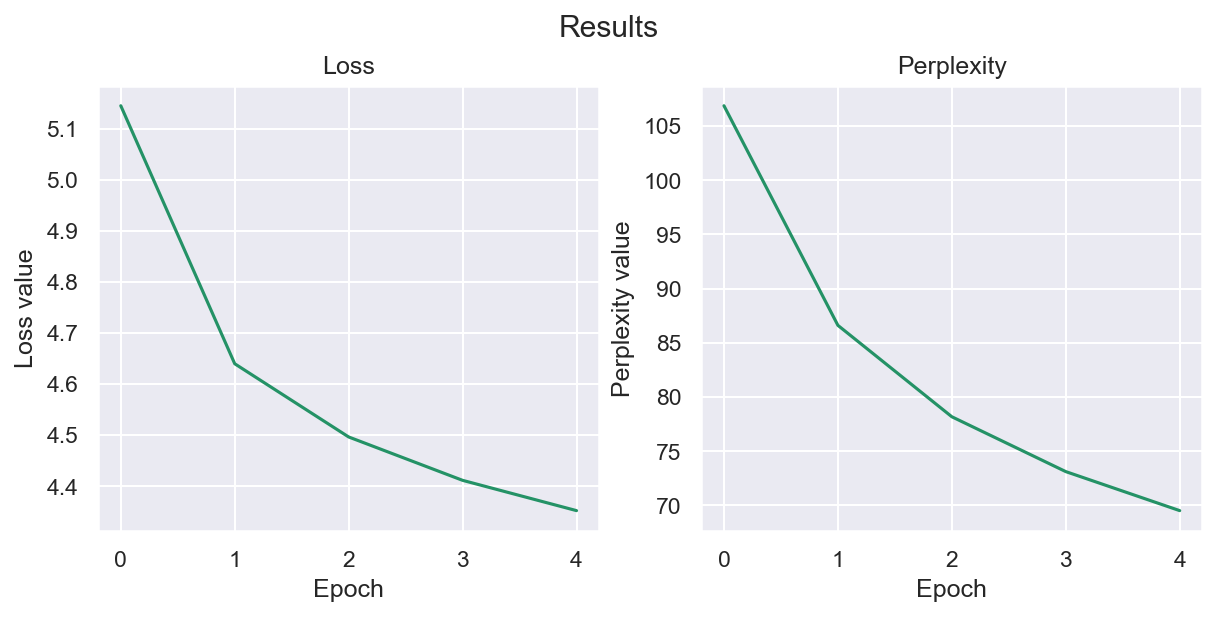

In [131]:
plot_results(m1_results)

In [132]:
print(f'Итоговое значение Perplexity', round(evaluate(m1_results.get('model'), criterion_1, eval_dataloader), 2))

Итоговое значение Perplexity 69.51


In [133]:
generate_sequence(m1_results.get('model'), starting_seq='the ultimate question of life, the universe, and everything', max_seq_len=128)

"<bos> the ultimate question of life , the universe , and everything is so bad that it 's not a good thing . <eos>"

### Второй эксперимент 

Во втором эксперименте предполагается использовать видоизменённую архитектуру языковой модели. Вектор каждого элемента последовательности конкатенируется с вектором скрытого состояния, полученного после обработки всей последовательности.

In [134]:
class WordLM_2(nn.Module):
    def __init__(self,  vocab_size: int, hidden_dim: tuple, embedding_size: int = 300, padding_ind: Optional[int] = None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_ind)
        self.rnn = nn.LSTM(embedding_size, hidden_dim[0], batch_first=True)
        self.linear_12 = nn.Linear(hidden_dim[0], hidden_dim[1])
    
        self.projection_1 = nn.Linear(2*hidden_dim[0], hidden_dim[0]) 
        self.projection_2 = nn.Linear(hidden_dim[1], vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, (h_n, c_n) = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim[0]]
        
        output = torch.cat((output, h_n[0].reshape((output.shape[0], 1, output.shape[2])).expand_as(output)), dim = -1) # [batch_size, seq_len, 2*hidden_dim[0]] - конкатенация векторов слов с итоговым вектором скрытого состояния последовательности
        output = self.projection_1(self.non_lin(output))
        output = self.linear_12(self.non_lin(output))
        output = self.projection_2(self.non_lin(output))
        return output

In [135]:
model_2 = WordLM_2(hidden_dim=(256, 128), vocab_size=len(vocab), padding_ind=word2ind['<pad>']).to(device)
criterion_2 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_2 = torch.optim.Adam(model_2.parameters())

In [136]:
m2_results = train_model(model_2, optimizer_2, criterion_2, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3519 [00:00<?, ?it/s]

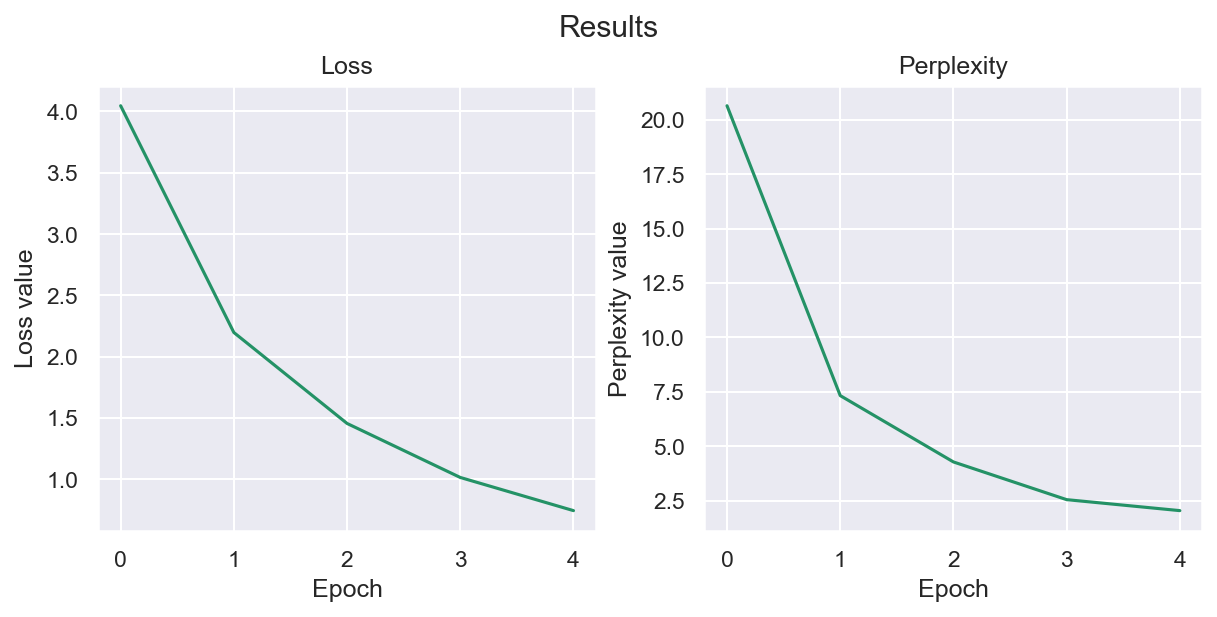

In [137]:
plot_results(m2_results)

In [138]:
print(f'Итоговое значение Perplexity', round(evaluate(m2_results.get('model'), criterion_2, eval_dataloader), 2))

Итоговое значение Perplexity 2.04


In [161]:
generate_sequence(m2_results.get('model'), starting_seq='the ultimate question of life, the universe, and everything', max_seq_len=128)

IndexError: tuple index out of range

### Третий эксперимент (2 балла)

Во третьем эксперименте предполагается использовать видоизменённую архитектуру языковой модели. Для прототипа нейросети в данном случае предполагается взять идею, напоминающую архитектуру `encoder-decoder`:
- Используются два рекуррентных слоя, один из которых представляет собой `encoder`, другой - `decoder`;
- Рекуррентные слои используют `LSTM` ячейки, количество слоёв типа `LSTM` `n_layers = 2`;
- Используются несколько вариаций линейных слоёв, которые позволяют совершать операции сжатия/декомпрессии векторов, простого преобразования между пространствами одной размерности.

In [162]:
class WordLM_3(nn.Module):
    def __init__(self,  vocab_size: int, hidden_dim: tuple, embedding_size: int = 300, num_rnn_layers: tuple = (1, 1), padding_ind: Optional[int] = None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_ind)
        self.rnn_r = nn.LSTM(embedding_size, hidden_dim[0], batch_first=True, num_layers = num_rnn_layers[0])
        self.rnn_e = nn.LSTM(hidden_dim[1], hidden_dim[0], batch_first=True, num_layers = num_rnn_layers[1])
        # Линейные слои для различных преобразований
        # Каждый линейный слой преобразует данные из размерности x в размерность y
        # Размерностям x и y соответствуют индексы 0 и 1 кортежа hidden_dim
        self.linear_11 = nn.Linear(hidden_dim[0], hidden_dim[0])
        self.linear_22 = nn.Linear(hidden_dim[1], hidden_dim[1])
        self.linear_12 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.linear_21 = nn.Linear(hidden_dim[1], hidden_dim[0])
        
        self.projection = nn.Linear(hidden_dim[0], vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        # Encoder like part
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn_r(embeddings)  # [batch_size, seq_len, hidden_dim[0]]
        output = self.linear_12(self.non_lin(output)) # [batch_size, seq_len, hidden_dim[1]] Понижается размерность вектора 
        output = self.non_lin(output) # [batch_size, seq_len, hidden_dim[1]] Понижается размерность вектора 

        # Decoder like part
        output = self.non_lin(self.linear_22(output)) # [batch_size, seq_len, hidden_dim[0]] Повышается размерность вектора
        output, _ = self.rnn_e(output)
        output = self.linear_11(self.non_lin(output)) # [batch_size, seq_len, hidden_dim[0]]
        output = self.dropout(output)  # [batch_size, seq_len, hidden_dim[0]]
        # output = self.linear_21(self.non_lin(output)) # [batch_size, seq_len, hidden_dim[1]] 
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [163]:
model_3 = WordLM_3(hidden_dim=(256, 128), vocab_size=len(vocab), padding_ind=word2ind['<pad>']).to(device)
criterion_3 = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer_3 = torch.optim.Adam(model_3.parameters())

In [164]:
m3_results = train_model(model_3, optimizer_3, criterion_3, train_dataloader, eval_dataloader)

Training epoch 0::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3519 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3519 [00:00<?, ?it/s]

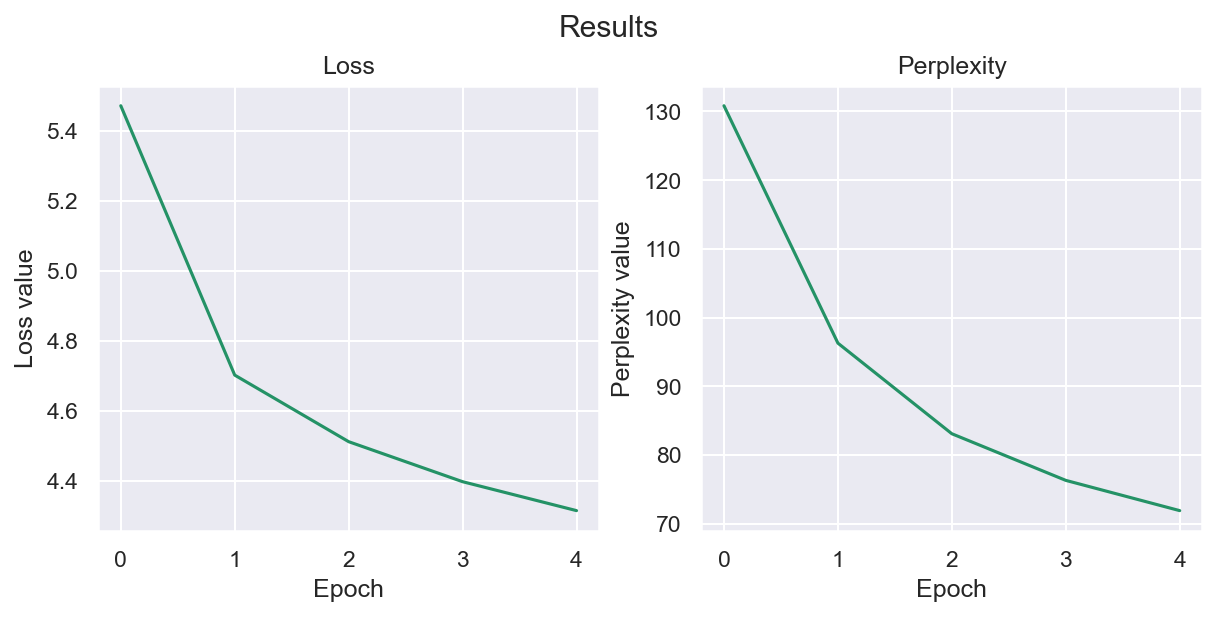

In [165]:
plot_results(m3_results)

In [166]:
print(f'Итоговое значение Perplexity', round(evaluate(m3_results.get('model'), criterion_3, eval_dataloader), 2))

Итоговое значение Perplexity 71.91


In [167]:
generate_sequence(m3_results.get('model'), starting_seq='the ultimate question of life, the universe, and ', max_seq_len=128)

'<bos> the ultimate question of life , the universe , and the <unk> , is a very good film . <eos>'

### Отчет (2 балла)

В рамках данной работы были проведены 3 эксперимента с различными архитектурами языковых моделей, использующих рекуррентные слои. 

*В эксперименте №2 было получено минимальное значение перплексии*, однако эксперимент не удался ввиду того, что в архитектурном решении не учитывается использование тензоров различных размерностей для проведения процесса инференса, полученное значение *перплексии* может быть недействительным ввиду невозможности проверки процесса инференса с помощью модели.

В рамках экспериментов 1 и 3 было совершено 5 эпох обучения моделей, были получены следующие результаты:
- *Эксперимент №1* - `WordLM_1`:
    ```
    WordLM_1(
  (embedding): Embedding(40004, 300, padding_idx=34741)
  (rnn): GRU(300, 256, num_layers=2, batch_first=True, dropout=0.2)
  (linear_12): Linear(in_features=256, out_features=128, bias=True)
  (linear_21): Linear(in_features=128, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)
    ```
    
- *Эксперимент №3* - `WordLM_1`:
    ```
    WordLM_3(
  (embedding): Embedding(40004, 300, padding_idx=34741)
  (rnn_r): LSTM(300, 256, batch_first=True)
  (rnn_e): LSTM(128, 256, batch_first=True)
  (linear_11): Linear(in_features=256, out_features=256, bias=True)
  (linear_22): Linear(in_features=128, out_features=128, bias=True)
  (linear_12): Linear(in_features=256, out_features=128, bias=True)
  (linear_21): Linear(in_features=128, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)
    ```


In [170]:
exp_data = {'model': ['WordLM_1', 'WordLM_3'],
           'loss': [m1_results.get('losses')[-1], m3_results.get('losses')[-1]],
           'perplexity': [m1_results.get('perplexities')[-1], m3_results.get('perplexities')[-1]]}
exp_data = pd.DataFrame(exp_data)
display(exp_data)

,model,loss,perplexity
0,WordLM_1,4.351775,69.509601
1,WordLM_3,4.314133,71.907525


In [173]:
generate_sequence(m1_results.get('model'), starting_seq='the ultimate question of life, the universe, and ', max_seq_len=128)

'<bos> the ultimate question of life , the universe , and the story is a bit too much . <eos>'

In [174]:
generate_sequence(m3_results.get('model'), starting_seq='the ultimate question of life, the universe, and ', max_seq_len=128)

'<bos> the ultimate question of life , the universe , and the <unk> , is a very good film . <eos>'

Среди представленных моделей оптимальной является модель `WordLM_1`, в которой используется `GRU` слой, значение целевой метрики перплексия для данной модели ниже, чем для модели `WordLM_3`. Число обучаемых параметров модели 1 значительно меньше по отношению к модели 3, так как в этой модели используется упрощённая версия рекуррентного слоя, а также более лёгкая архитектура. 

В процессе генерации текста модель 1 в режиме `beam search` реже генерирует токены `unk` по отношению к модели `3`

*Улучшение качества работы моделей:*
- использовать иные оптимизаторы типа `RMSProp`, `SGD`; настраивать их `learning_rate`, иные гиперпараметры;
- использовать фреймворк `optuna` для реализации процесса оптимизации гиперпараметров какой-либо из выбранных моделей;
- добавить в представленные ранее архитектуры слои-регуляризаторы;
- для представленных моделей увеличить число эпох обучения и изменить подход к предобработке корпусов текста.